# Managing offline map areas

## Introduction

With ArcGIS you can take your web maps and layers offline to reliably work with your GIS data in disconnected scenarios when connectivity is intermittent or unavailable. 

To learn about the concepts, steps, data requirements and applications that support taking a map offline, refer to the appropriate documentation pages:

* [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/manage-data/take-maps-offline.htm)
* [ArcGIS Enterprise](https://enterprise.arcgis.com/en/portal/latest/use/take-maps-offline.htm)
 

Once web maps have been prepared, certain applications in the ArcGIS Platform, and the [ArcGIS Runtime SDKs](https://developers.arcgis.com/features/offline/) allow you to build applications that can utitlize these maps while remaining disconnected. These workflows all make use of [_offline map areas_](https://doc.arcgis.com/en/arcgis-online/manage-data/take-maps-offline.htm#ESRI_SECTION1_AB810E1B98EA4F248C3A7F22CB20DDFB), which A GIS administrator or [web map](/python/api-reference/arcgis.mapping.toc.html#webmap) owner can define in one of two ways:

* ahead of the time field workers will download these areas for offline use, known as _preplanned map areas_
* at the time field workers actually need to download them for use, known as _on-demand map areas_

Making map areas ahead of time is the *recommended* workflow because the map author can ensure accuracy of the offline content and packaging of offline contents occurs only once. Packaged content can be used by mutliple workers to increase performance. This guide describes how to use the ArcGIS API for Python to create **preplanned offline map areas** for use in custom ArcGIS Runtime SDK apps or Esri applications such as [ArcGIS Field Maps](https://doc.arcgis.com/en/field-maps/android/help/configure-the-map.htm#ESRI_SECTION1_1822CD8DD1E74F08BC4308E03A5677F1).

Let's get started with the API to demonstrate preparing areas ahead of time.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Managing-offline-map-areas" data-toc-modified-id="Managing-offline-map-areas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Managing offline map areas</a></span><ul class="toc-item"><li><span><a href="#Creating-offline-map-areas" data-toc-modified-id="Creating-offline-map-areas-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating offline map areas</a></span><ul class="toc-item"><li><span><a href="#Inspecting-offline-packages-created-for-a-map-area" data-toc-modified-id="Inspecting-offline-packages-created-for-a-map-area-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Inspecting offline packages created for a map area</a></span></li></ul></li><li><span><a href="#Listing-offline-areas-created-for-a-web-map" data-toc-modified-id="Listing-offline-areas-created-for-a-web-map-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Listing offline areas created for a web map</a></span></li><li><span><a href="#Updating-offline-areas" data-toc-modified-id="Updating-offline-areas-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Updating offline areas</a></span></li></ul></li></ul></div>

## Creating offline map areas

With ArcGIS API for Python, you can conveniently manage offline areas from a _`WebMap`_ object. The [`offline_areas`](/python/api-reference/arcgis.mapping.toc.html#arcgis.mapping.WebMap.offline_areas) property accesses the [`OfflineMapAreaManager`](/python/api-reference/arcgis.mapping.toc.html#offlinemapareamanager) object with which you can administer all aspects of offline map area management, from creating, to listing to updating. Let's take a look:

In [2]:
from arcgis.gis import GIS
from arcgis.mapping import WebMap

In [ ]:
gis = GIS(profile="your_online_admin_profile")

Let us use a fire first responder web map and take it offline.

<Item title:"Middle Little Missouri Sub Basin Wetlands and Riparian Areas" type:Web Map owner:online_admin_user>
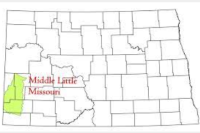

In [4]:
#wm_item = gis.content.get('3e7159ee4c6c4e6faf2ca2bd066ee972')
wm_item = gis.content.get("6d7330a7f3f5438ebcbc6fe23f8abcc8")
wm_item

In [5]:
wm_obj = WebMap(wm_item)

You can create offline areas for a specified extent, a specific polygon, or a bookmark. You can additionally specify any layers that you need to ignore, a destination folder to store these packages and a minimum and maximum scale to which the packages need to be cached. Let's examine a couple examples:

### Creating offline areas with _Bookmarks_
We're working with a _web map_ depicting wetlands data from subwatersheds within the Little Missouri River basin area of North Dakota. We've created [`bookmarks`](/python/api-reference/arcgis.mapping.toc.html#arcgis.mapping.WebMap.bookmarks) in the _web map_ for areas surrounding three subwatersheds:

In [70]:
for bookmark in wm_obj.definition.bookmarks:
    print(bookmark.name)

Lower Garner Creek
Merrifield Creek
Bear Creek


We'll create an offline area for the bookmark called "Lower Garner Creek". We'll also limit the data extracted into the offline map area package to specific layers in the web map. We'll include a subwatershed boundaries layer and a wetlands layer designating features we want our field workers to update. Let's first look at the list of layers from our web map so we know how to create a list of layers for the `ignore_layers` argument. We'll import the [`FeatureLayer`](/python/api-reference/arcgis.features.toc.html#arcgis.features.FeatureLayer) class to examine some properties of each layer in the web map:

In [11]:
from arcgis.features import FeatureLayer

for wmlyr in wm_obj.layers:
    flyr = FeatureLayer(wmlyr['url'], gis)
    print(f"{flyr.properties.id:<3}{flyr.properties.name}\n{' '*2}{wmlyr.url}")

0  Non_Populated_GNIS_Places
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/0
1  Populated_GNIS_Place_Names
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/1
2  Middle Little Missouri Wetlands
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/2
3  Middle Little Missouri Riparian Areas
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/3
4  Theodore_Roosevelt_National_Park
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/4
5  Sub_Watershed Boundaries
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_

We only want to include layer 2, and layer 5. So let's use a list comprehension to create a list of the urls for the feature layers we want to ignore:

In [13]:
flyrs_to_ignore = [fl["url"] for fl in wm_obj.layers if not fl["url"][-1] in ["2", "5"]]
flyrs_to_ignore

['https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/0',
 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/1',
 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/3',
 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/4',
 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer/6']

We'll also set the farthest scale users will zoom out to view layers in the package with the `min_scale` argument. In addition, we'll use the `item_properties` parameter to specify properties for the resulting _Map Area item_. We'll specify the _title_, _description_, and _tags_ for the _item_ that gets created. 

This operation can take a while as the server is packaging the contents of the web map for offline use. To view the status, you can optionally turn on the verbosity using the `env` module as shown below:

```python
from arcgis import env
env.verbose = True
```

> **Note:** You must own the _web map_ or be an organization administrator to run this operation.

In [15]:
offline_item_properties = {"title": "Offline area for Lower Garner Creek Subwatershed",
                          "tags": ["Python", "automation", "hydrology", "wetlands"],
                          "snippet": "Area created for updating wetlands and riparian areas."}

lower_garner_offline_item = wm_obj.offline_areas.create(area = wm_obj.definition.bookmarks[0].name,
                                                        item_properties = offline_item_properties,
                                                        min_scale = 210000,
                                                        max_scale = 0,
                                                        ignore_layers= flyrs_to_ignore,
                                                        folder="Wetlands_Inventory")

We can now use the [`list()`](/python/api-reference/arcgis.mapping.toc.html#arcgis.mapping.OfflineMapAreaManager.list) method on the _web map_ object to examine the resulting [item](/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item):

In [26]:
wm_obj.offline_areas.list()

[<Item title:"Offline area for Lower Garner Creek Subwatershed" type:Map Area owner:online_admin_user>]

Notice the _type_ attribute of the item is _Map Area_.

### Create offline areas with an _Extent_

We can also use an _extent_ object to create an offline map area. An extent defines a bounding box by specifying coordinate pairs for both the lower-left and upper-right corners. You can define an _extent_ yourself with coordinates that lie within the entire extent of the web map, or use existing features within web map layers to define an extent.

We can define a smaller area within the bounds of our data using latitude and longitude coordinates for an area we know is within our overall extent. For this dataset, we know we are in southwestern North Dakota, so we'll define an extent covering a subarea of a subwatershed named Middlefield Creek within the basin.

When using an _extent_ for the `area` argument the format needs to be a list of 2 coordinate pairs:

extent_coordinates = [[_x minimum_, _y minimum_], [_x maximum_, _y maximum_]]

In [46]:
mfield_sub_extent = [[-103.56, 46.76], [-103.50, 46.80]]

In [47]:
offline_item_properties = {"title": "Offline area for mid-section of Merrifield Creek Subwatershed",
                          "tags": ["Python", "automation", "hydrology", "wetlands"],
                          "snippet": "Area created for updating wetlands and riparian areas in Little Missouri River basin."}

merrifield_offline_item = wm_obj.offline_areas.create(area = mfield_sub_extent,
                                                        item_properties = offline_item_properties,
                                                        min_scale = 210000,
                                                        max_scale = 0,
                                                        ignore_layers= flyrs_to_ignore,
                                                        folder="Wetlands_Inventory")

Using the same _list()_ method as above, we can now see that we have two _Map Area_ items for this web map.

In [48]:
print(wm_obj.offline_areas.list())

[<Item title:"Offline area for mid-section of Merrifield Creek Subwatershed" type:Map Area owner:online_admin_user>, <Item title:"Offline area for Lower Garner Creek Subwatershed" type:Map Area owner:online_admin_user>]


### Create offline areas from a specific polygon

We can also create an offline map area using an instance of a _polygon_ [geometry](/python/api-reference/arcgis.geometry.html#polygon) to define the geographic area. We can extract a polygon from one of our layers.

In [56]:
from arcgis.geometry import Polygon

subwatershed_lyr = FeatureLayer(wm_obj.layers[5]["url"], gis)
bear_ck = subwatershed_lyr.query(where="name = 'Bear Creek'").features[0]
bear_ck_poly = Polygon(bear_ck.geometry)

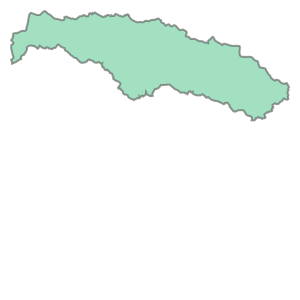

In [57]:
bear_ck_poly

In [58]:
offline_item_properties = {"title": "Offline area for Bear Creek Subwatershed",
                          "tags": ["Python", "automation", "hydrology", "wetlands"],
                          "snippet": "Area created for updating wetlands and riparian areas in Bear Creek subwatershed in the Little Missouri River basin."}

merrifield_offline_item = wm_obj.offline_areas.create(area = bear_ck_poly,
                                                        item_properties = offline_item_properties,
                                                        min_scale = 210000,
                                                        max_scale = 0,
                                                        ignore_layers= flys_to_ignore,
                                                        folder="Wetlands_Inventory")

In [59]:
wm_obj.offline_areas.list()

[<Item title:"Offline area for mid-section of Merrifield Creek Subwatershed" type:Map Area owner:online_admin_user>,
 <Item title:"Offline area for Bear Creek Subwatershed" type:Map Area owner:online_admin_user>,
 <Item title:"Offline area for Lower Garner Creek Subwatershed" type:Map Area owner:online_admin_user>]

We've used three different ways of specifying a geographic area to create offline mapping ares for our web map. Now it's time to inspect the _Map Area_ items to get some additional information. As we saw earlier, the _create()_ method results in _items_ with a _type_ attribute of _Map Area_. We can loop through our list to see this:

In [62]:
for oma_item in wm_obj.offline_areas.list():
    print(f"{oma_item.title:65}{oma_item.type}")

Offline area for mid-section of Merrifield Creek Subwatershed    Map Area
Offline area for Bear Creek Subwatershed                         Map Area
Offline area for Lower Garner Creek Subwatershed                 Map Area


## Inspecting offline packages created for a map area

When you create an offline map area, the data for the specified extent is bundled into one or many packages for downloading depending upon the types of layers in the _web map_. _Feature Layers_ are packaged into mobile geodatabases, while _tile layers_ and _vector tile layers_ are bundled into tile packages and vector tile packages, respectively. See the [Create and manager offline map areas documentation](https://doc.arcgis.com/en/arcgis-online/manage-data/take-maps-offline.htm#ESRI_SECTION1_8C6055E984D34AF4A25B989DDCAACF87) for details.

The packages created for a `Map Area` item share a relationship with the item. The relationship type is an `Area2Package` relation with a forward direction. See the [Relationship types]() documentation for a comprehensive list of possible relations between items. Any _item_ has the [`related_items()`](/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.related_items) method from which you can retrieve the items that participate in the specific relationship type:

In [65]:
for oma_item in wm_obj.offline_areas.list():
    print(f"{oma_item.title} shares the `Area2Package` relationship with: \n{'-' * 50}")
    for rel_item in oma_item.related_items('Area2Package', 'forward'):
        print(f"{' '*2}{rel_item.title:55}\n{' '*4}{rel_item.type}")
    print("\n")

Offline area for mid-section of Merrifield Creek Subwatershed shares the `Area2Package` relationship with: 
--------------------------------------------------
  Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas-380a6e66592d41219f5efeb076b9286e
    SQLite Geodatabase


Offline area for Bear Creek Subwatershed shares the `Area2Package` relationship with: 
--------------------------------------------------
  VectorTileServe-77514eec74ac400a98a6026440a4e7f6       
    Vector Tile Package
  Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas-2cd25cf0ca7b4267904f4dc831bd6a71
    SQLite Geodatabase


Offline area for Lower Garner Creek Subwatershed shares the `Area2Package` relationship with: 
--------------------------------------------------
  Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas-f04e141cf75842b0821664b4e8ab6233
    SQLite Geodatabase
  VectorTileServe-a971522fa2ec43a08b76565b146fdbe4       
    Vector Tile Package




These items are meant for use in offline applications like _ArcGIS Field Maps_, [ArcGIS Survey123](https://doc.arcgis.com/en/survey123/desktop/create-surveys/preparebasemaps.htm), or [ArcGIS Runtime SDK](https://links.esri.com/agol-help/runtime-sdk/offline) applicatons. If needed, you can call the [`download()`](/python/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.download) method of the _Map Area item_ to download the data to disk.

## Updating offline areas
The layer data used to create the offline map areas may change, so keeping offline areas up to date is an important task.  The [`update()`](/python/api-reference/arcgis.mapping.toc.html#arcgis.mapping.OfflineMapAreaManager.update) method of the _OfflineMapAreaManager_ class accomplishes this. The method accepts a _list_ of _Map Area items_ as input. If no _items_ are specified in the `items` argument, all _map area items_ for the _web map_ get updated. 

Below is an example of how the progress is relayed back to you when you turn on the `verbosity` in the `env` module.

In [67]:
from arcgis import env
env.verbose=True

In [68]:
# update all offline areas for the fire web map
wm_obj.offline_areas.update()

Submitted.
Executing...
Start Time: Wednesday, August 02, 2023 12:13:43 AM
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Get Service Definition
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Submit sync job
World_Basemap_v2/VectorTileServer - Submit export job
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Get Service Definition
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Submit sync job
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Get Service Definition
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Submit sync job
World_Basemap_v2/VectorTileServer - Submit export job
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Add/Update package item
Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer - Add/Update package item
Middle_Little_Missouri_SubBasin_Wetlands_and

[{'source': 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer',
  'itemId': '36d7b8e5bfe74b37a07eaad00be4033d',
  'state': 'unchanged'},
 {'source': 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer',
  'itemId': 'c74db213e5b94ce486d07f29fb240b80',
  'state': 'unchanged'},
 {'source': 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Middle_Little_Missouri_SubBasin_Wetlands_and_Riparian_Areas/FeatureServer',
  'itemId': 'd6a380a85291455382e7eb52870420d4',
  'state': 'unchanged'},
 {'source': 'https://basemaps.arcgis.com/arcgis/rest/services/World_Basemap_v2/VectorTileServer',
  'itemId': '6ac731fed6c14a0aa516dc8dbe4b5b77',
  'state': 'updated'},
 {'source': 'https://basemaps.arcgis.com/arcgis/rest/services/World_Basemap_v2/VectorTileServer',
  'itemId': 'b458a7d78a7148f7b53beed1124ccfe0'

Now any field users are all set with the latest packages for use in a disconnected setting.